<a href="https://colab.research.google.com/github/leyixu21/master_thesis/blob/main/clean_flickr_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

In [4]:
! pip install flickrapi
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
from flickrapi import FlickrAPI
import pandas as pd
from pandas.io.formats.format import NA
import numpy as np
import datetime
import re
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import pickle
import folium
import geopandas as gpd
import tqdm


In [7]:
# set paths
path='/content/drive/MyDrive/master_thesis_data/flickr/'

# Preprocess Flickr Data

## Read and Manage Data

In [ ]:
# combine data in 2012 and 2013
gdf = []
for y in range(2012, 2014):
  gdf_y = gpd.read_file(path+'london_flickr_'+str(y)+'.geojson')
  gdf.append(gdf_y)
gdf = pd.concat(gdf)

In [ ]:
# select necessary columns
gdf = gdf[['owner', 'accuracy', 'datetaken', 'tags', 'title', 'geometry']]

# convert string to datetime format
gdf['datetaken'] = pd.to_datetime(gdf['datetaken'], format='%Y-%m-%d %H:%M:%S')
# get date
gdf['date'] = gdf['datetaken'].apply(lambda x: x.date())
# sort by datetaken
gdf = gdf.sort_values(by='datetaken')

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# select data from 2012-04-03 to 2013-09-16
start_date = pd.to_datetime('2012-04-03', format='%Y-%m-%d')
end_date = pd.to_datetime('2013-09-16', format='%Y-%m-%d')
gdf = gdf[(gdf['date']>=start_date)&(gdf['date']<=end_date)]

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [ ]:
gdf

,Unnamed: 0,accuracy,context,datetaken,datetakengranularity,datetakenunknown,farm,geo_is_contact,geo_is_family,geo_is_friend,...,place_id,secret,server,tags,title,url_n,views,width_n,woeid,geometry
0,17,15.0,0.0,2012-01-01 08:03:43,0.0,0.0,8.0,0.0,0.0,0.0,...,None,845b59717c,7156.0,london millenniumwheel panoramic stitched thel...,London skyline from the Millennium Wheel The L...,https://live.staticflickr.com/7156/6612991557_...,1128.0,320.0,24875645.0,POINT (-0.11912 51.50391)
1,14,15.0,0.0,2012-01-01 08:07:43,0.0,0.0,9.0,0.0,0.0,0.0,...,AggqPb1TUrohNNCS.A,e1ccdf4562,8360.0,None,The Shard 2012-01-01 08.07.44,https://live.staticflickr.com/8360/8431186622_...,6.0,240.0,20094296.0,POINT (-0.08821 51.50656)
2,21,16.0,0.0,2012-01-01 08:27:39,0.0,0.0,8.0,0.0,0.0,0.0,...,RzhElMBTULgOpw,0e1045a311,7165.0,ryanmullen,Ryan 01.01.12,https://live.staticflickr.com/7165/6732863697_...,118.0,320.0,22245.0,POINT (-0.31500 51.44132)
3,17,16.0,0.0,2012-01-01 08:38:22,0.0,0.0,8.0,0.0,0.0,0.0,...,AggqPb1TUrohNNCS.A,c5f4147c3f,7202.0,None,DSCF5198,https://live.staticflickr.com/7202/6960088675_...,7.0,320.0,20094296.0,POINT (-0.08392 51.50841)
4,7,16.0,0.0,2012-01-01 08:44:47,0.0,0.0,8.0,0.0,0.0,0.0,...,fqGSiwFTULimXw,da35dac2bc,7164.0,city uk england urban london bush pub holly ha...,Holly Bush Alley,https://live.staticflickr.com/7164/6705593969_...,136.0,320.0,22291.0,POINT (-0.17952 51.55753)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447725,2268,15.0,0.0,2013-12-31 12:54:46,0.0,0.0,8.0,0.0,0.0,0.0,...,5PTridlSUb_r5g,2a1b70bb40,7368.0,indie laurie,NaN,https://live.staticflickr.com/7368/11771429694...,784.0,320.0,33592.0,POINT (-0.04259 51.50115)
447726,1501,16.0,0.0,2013-12-31 12:55:30,0.0,0.0,4.0,0.0,0.0,0.0,...,ItvAHJNTUrpZ8OlyOw,9e7f54d5e3,3746.0,uploaded:by=flickrmobile flickriosapp:filter=n...,NaN,https://live.staticflickr.com/3746/11676142343...,2.0,240.0,20094309.0,POINT (-0.13166 51.51103)
447727,5432,16.0,0.0,2013-12-31 12:56:30,0.0,0.0,4.0,0.0,0.0,0.0,...,g6k_VpZQVb96VQ,969b36a87f,3717.0,square squareformat iphoneography instagramapp...,NaN,https://live.staticflickr.com/3717/11666497975...,18.0,320.0,17581.0,POINT (-0.00519 51.48085)
447728,1104,16.0,0.0,2013-12-31 12:58:09,0.0,0.0,6.0,0.0,0.0,0.0,...,RYyhyPFTUrptz.7WRQ,4bebfb68d5,5493.0,None,NaN,https://live.staticflickr.com/5493/11734619904...,493.0,320.0,20089578.0,POINT (-0.09383 51.51925)


In [ ]:
len(list(gdf['owner'].unique()))

28633

In [ ]:
# remove photos with no tags
gdf = gdf.dropna(subset=['tags'])

In [ ]:
# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

len(tags_unique)

250254

Remove photos with accuracy below 14

In [ ]:
# remove photos with accuracy lower than 14
gdf = gdf[gdf['accuracy']>=14]

save point

In [ ]:
# gdf.to_pickle(path+'gdf_merged.pkl')
gdf = pd.read_pickle(path+'gdf_merged.pkl')

## Clean Tags

Remove non-English tags and tags with non-Ascii characters, special characters, numbers, and stop-word

In [ ]:
# define a function to detect non-Ascii characters
def containsNonAscii(s):
  return any(ord(i)>127 for i in s)

# define a function to detect special characters and numbers
def containsNonSpecialChar(s):
  return bool(re.match('^[a-zA-Z]*$',s))

# define a function to detect stop-words and prepositions
def containsNonStopW(s):
  return s != 'a' and s != 'an' and s != 'the' and s!= 'from' and s!= 'to'

# define a function to detect general place names
def containsNonGeneralP(s):
  general_places = ['gb', 'britain', 'united', 'kingdom', 'uk', 'england', 'london', 'londres', 'londen']
  return all(x not in s for x in general_places)

# define a function to detect irrelevant tags
def containsNonIrreT(s):
  irrelevant = ['camera', 'nikon', 'canon', 'dslr', 'fuji', 'hdr', 'sony', 'samsung', 'iphoneography', 'instagram', 'flickr', 'zefrog']
  return all(x not in s for x in irrelevant)



for i, row in gdf.iterrows():
  # split the tag string to the list
  words = row['tags'].split()
  # remove tags defined by the above functions
  cleaned_words = [word for word in words if not containsNonAscii(word)]
  cleaned_words = [word for word in cleaned_words if containsNonSpecialChar(word)]
  cleaned_words = [word for word in cleaned_words if containsNonStopW(word)]
  cleaned_words = [word for word in cleaned_words if containsNonGeneralP(word)]
  cleaned_words = [word for word in cleaned_words if containsNonIrreT(word)]
  # remove duplicates in the same tag list
  cleaned_words = list(set(cleaned_words))
  # convert the tag list back to the string
  cleaned_words = ' '.join(cleaned_words)
  gdf['tags'][i] = cleaned_words

# remove photos with no tags again
gdf = gdf.dropna(subset=['tags'])


Replace abbreviations with full names (not applied)

In [ ]:
# # replace abbreviations with full names
# gdf['tags'] = gdf['tags'].apply(lambda x: x.replace('gbr', 'greatbritishrestaurant'))
# gdf['tags'] = gdf['tags'].apply(lambda x: x.replace('tfl', 'transportforlondon'))
# gdf['tags'] = gdf['tags'].apply(lambda x: x.replace('bw', 'workplaceexperts'))
# gdf['tags'] = gdf['tags'].apply(lambda x: x.replace('lhr', 'heathrowairport'))
# gdf['tags'] = gdf['tags'].apply(lambda x: x.replace('bt', 'postofficetower'))
# gdf['tags'] = gdf['tags'].apply(lambda x: x.replace('rhs', 'royalhorticulturalsociety'))
# gdf['tags'] = gdf['tags'].apply(lambda x: x.replace('smg', 'shoppingmediagroup'))
# gdf['tags'] = gdf['tags'].apply(lambda x: x.replace('tvc', 'televisioncentre'))

Save Point

In [ ]:
# gdf.to_pickle(path+'gdf_clean_tags.pkl')
gdf = pd.read_pickle(path+'gdf_clean_tags.pkl')

## Clean Users

Remove duplicates

In [ ]:
# remove duplicates
gdf = gdf.drop_duplicates(subset=['owner', 'tags', 'geometry'])

In [ ]:
# group data by users
gdf_gb_users = gdf.groupby('owner')

# get the list of users
users = list(gdf_gb_users.groups.keys())

Remove unprolific users

In [ ]:
# remove users who took less than 5 photos in total at different places over a 24-h period
# iterate the users
for i in users:
  user = gdf_gb_users.get_group(i)
  # group data of the specific user by date
  user_gb_date = user.groupby('date', as_index=False)
  # count the number of photos this user took each day
  user_gb_date_count = user_gb_date.count()
  # get the list of dates when the photos were less than 5
  date_sparse = user_gb_date_count[user_gb_date_count['tags'] < 5].date.to_list()
  # remove users who uploaded sparse photos within a day
  gdf = gdf[(gdf['owner'] != i) | (~gdf['date'].isin(date_sparse))]


# group data by users again
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())

Remove prolific users

In [ ]:
# remove users who uploaded more than 5% photos of the dataset
# count the number of photos each user uploaded
gdf_gb_users_count = pd.DataFrame(gdf_gb_users.count())
# calculate the percent of photos each user uploaded
gdf_gb_users_count['percent'] = (gdf_gb_users_count['tags'] / gdf_gb_users_count['tags'].sum()) * 100
gdf_gb_users_count = gdf_gb_users_count.sort_values('percent', ascending=False)

# get the id of users who uploaded too many photos
users_prolific = gdf_gb_users_count[gdf_gb_users_count['percent'] > 5].owner
# remove prolific users
gdf = gdf[~gdf['owner'].isin(users_prolific)]


Save Point

In [8]:
# save the data as pickle
# gdf.to_pickle(path+'gdf_clean_users.pkl')
gdf = pd.read_pickle(path+'gdf_clean_users.pkl')

## Reduce Tags Bias (Old)

Both two sections under this section are not executed because the data quality of tags is good

In [ ]:
# create a dictionary to store the tags used by each user
users_tags = {}
for i in users:
  user = gdf_gb_users.get_group(i)
  # get the tags used by the user
  user_tags = list(user['tags'].apply(lambda x: x.split()))
  user_tags = list(np.concatenate(user_tags).flat)
  users_tags[i] = user_tags

In [ ]:
# create a dictionary to store the usage frequency of tags over users
tags_freq = {}
tags_users_freq = {}
for i in tqdm.tqdm(tags_unique):
  # store the number of users who used the tag
  tag_count = 0
  # create a list to store the tag usage frequency of each user
  tag_users = []
  for j in users:
    user_tags = users_tags[j]
    # get the frequency of the tag used by the user
    freq = user_tags.count(i)
    # count the number of users who used the tag
    if freq != 0:
      tag_count += 1
    # store the tag usage frequency of each user
    tag_users.append(freq)
  tags_freq[i] = tag_count
  tags_users_freq[i] = tag_users


# convert the tags_freq dictionary to the dataframe
tags_freq = pd.Series(tags_freq).to_frame(name='count').reset_index()
tags_freq = tags_freq.rename(columns={'index': 'tags'})

# convert the tags_users_freq dictionary to the dataframe
tags_users_freq = pd.Series(tags_users_freq).to_frame(name='count').reset_index()
tags_users_freq = tags_users_freq.rename(columns={'index': 'tags'})



Save Point

In [ ]:
# # save two datasets as pickle
# tags_freq.to_pickle(path+'tags_freq.pkl')
# tags_users_freq.to_pickle(path+'tags_users_freq.pkl')

tags_freq = pd.read_pickle(path+'tags_freq.pkl')
tags_users_freq = pd.read_pickle(path+'tags_users_freq.pkl')

### Remove Tags used by only one user

In [ ]:
tags_freq

In [ ]:
# create a list to store the tags used by only one user
tags_remove = []

# iterrate through the tags_freq
for idx, row in tags_freq.iterrows():
  if row['count'] == 1:
    tags_remove.append(row['tags'])

print(len(tags_unique))
print(len(tags_remove))

### Remove Tags based on CV

In [ ]:
tags_users_freq

In [ ]:
# add a column in tags_users_freq to store the coefficient of variation
tags_users_freq['cv'] = 0

# get the coefficient of variation of tags based on the frequency
tags_users_freq['cv'] = tags_users_freq['count'].apply(lambda x: np.std(x, ddof=1) / np.mean(x))

tags_users_freq
# remove tags based on cv
# gdf = 

# # remove photos with no tags again
# gdf = gdf.dropna(subset=['tags'])

## Reduce Tags Bias (New)

Both two sections under this section are not executed because the data quality of tags is good

In [83]:
# group data by users
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users in an order of contributions (most prolific users on the top)
users = list(gdf_gb_users.count().sort_values('accuracy', ascending=False)['owner'])

# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

In [84]:
tags_count.most_common()

[('square', 13528),
 ('squareformat', 11877),
 ('city', 10557),
 ('architecture', 8834),
 ('street', 7514),
 ('thames', 7183),
 ('people', 7135),
 ('europe', 6869),
 ('park', 6648),
 ('cycle', 4981),
 ('river', 4860),
 ('bus', 4753),
 ('summer', 4615),
 ('art', 4504),
 ('greenwich', 4238),
 ('building', 4094),
 ('urban', 4036),
 ('westminster', 3997),
 ('cycles', 3987),
 ('candid', 3975),
 ('bridge', 3971),
 ('diary', 3962),
 ('existence', 3958),
 ('lifeblogging', 3956),
 ('egzystencja', 3956),
 ('lifeblog', 3956),
 ('lifelog', 3956),
 ('biorhythms', 3956),
 ('monotonyoflife', 3956),
 ('biorytmy', 3956),
 ('graffiti', 3877),
 ('riverthames', 3843),
 ('geotagged', 3738),
 ('heathrow', 3664),
 ('station', 3600),
 ('night', 3573),
 ('bw', 3532),
 ('lhr', 3493),
 ('travel', 3376),
 ('gbr', 3302),
 ('olympics', 3216),
 ('blackandwhite', 3211),
 ('british', 3183),
 ('tower', 3138),
 ('museum', 3126),
 ('great', 3101),
 ('railway', 3086),
 ('shoreditch', 2896),
 ('tube', 2883),
 ('underground

In [81]:
# get the number of photos uploaded by each user
gdf_gb_users.count().sort_values('accuracy', ascending=False)

,owner,accuracy,datetaken,tags,title,geometry,date
862,24389194@N00,4856,4856,4856,3118,4856,4856
2280,47121377@N00,3581,3581,3581,2186,3581,3581
1904,41087279@N00,3310,3310,3310,2441,3310,3310
3963,77392150@N02,2542,2542,2542,2542,2542,2542
4646,90484572@N00,1801,1801,1801,902,1801,1801
...,...,...,...,...,...,...,...
2093,44124400583@N01,5,5,5,0,5,5
2089,44104610@N05,5,5,5,5,5,5
2088,44085687@N06,5,5,5,0,5,5
4375,84761937@N00,5,5,5,5,5,5


In [85]:
# create a dictionary to store the tags used by each user
users_tags = {}
for i in tqdm.tqdm(users):
  user = gdf_gb_users.get_group(i)
  # get the tags used by the user
  user_tags = list(user['tags'].apply(lambda x: x.split()))
  user_tags = list(np.concatenate(user_tags).flat)
  users_tags[i] = user_tags


100%|██████████| 5157/5157 [00:08<00:00, 601.56it/s]


### Remove Tags used by only one user

There are a large number of tags used by only several users, thus this section is not exceuted (these tags will not be removed)

In [1]:
# create a dictionary to store the number of users who used specific tags
tags_freq = {}
for i in tqdm.tqdm(tags_unique):
  # store the number of users who used the tag
  tag_count = 0
  for j in users:
    user_tags = users_tags[j]
    # get the frequency of the tag used by the user
    freq = user_tags.count(i)
    # count the number of users who used the tag
    if freq != 0:
      tag_count += 1

  tags_freq[i] = tag_count


# convert the tags_freq dictionary to the dataframe
tags_freq = pd.Series(tags_freq).to_frame(name='count').reset_index()
tags_freq = tags_freq.rename(columns={'index': 'tags'})

NameError: ignored

In [18]:
tags_freq

,tags,count
0,forms,5
1,bw,798
2,glass,513
3,circles,34
4,duotone,6
...,...,...
79799,leadtrough,1
79800,streettrees,1
79801,oakleighpark,1
79802,finchleycentralstation,1


In [19]:
# create a list to store the tags used by only one users
tags_remove = []

# iterrate through the tags_freq
for idx, row in tags_freq.iterrows():
  if row['count'] == 1:
    tags_remove.append(row['tags'])

print(len(tags_unique))
print(len(tags_remove))


79804
40396


In [36]:
# get users who use tags in tags_remove from users_tags
tags_remove_users = []
for i in tqdm.tqdm(tags_remove):
  for j in users_tags:
    if i in users_tags[j]:
      tags_remove_users.append(j)

100%|██████████| 40396/40396 [17:54<00:00, 37.60it/s]


In [44]:
# remove users who use tags in tags_remove from gdf
gdf = gdf[~gdf['owner'].isin(tags_remove_users)]


In [48]:
# group data by users
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users in an order of contributions (most prolific users on the top)
users = list(gdf_gb_users.count().sort_values('accuracy', ascending=False)['owner'])

# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

In [47]:
tags_count.most_common()

[('square', 3397),
 ('squareformat', 3243),
 ('europe', 1310),
 ('city', 979),
 ('architecture', 964),
 ('thames', 852),
 ('street', 793),
 ('photostream', 731),
 ('travel', 705),
 ('bridge', 648),
 ('park', 549),
 ('vacation', 496),
 ('trip', 477),
 ('people', 467),
 ('angleterre', 467),
 ('greenwich', 462),
 ('shard', 450),
 ('river', 442),
 ('londra', 438),
 ('blackandwhite', 435),
 ('towerbridge', 433),
 ('westminster', 431),
 ('night', 412),
 ('building', 380),
 ('tower', 379),
 ('bw', 379),
 ('iphone', 376),
 ('lofi', 370),
 ('british', 361),
 ('riverthames', 353),
 ('summer', 343),
 ('art', 340),
 ('inglaterra', 338),
 ('olympics', 335),
 ('sky', 333),
 ('urban', 323),
 ('train', 300),
 ('graffiti', 294),
 ('tube', 288),
 ('amaro', 285),
 ('compact', 279),
 ('pointandshoot', 278),
 ('october', 276),
 ('museum', 265),
 ('xproii', 265),
 ('europa', 265),
 ('photography', 264),
 ('dogwalkerbalham', 250),
 ('dogwalkerclapham', 244),
 ('monochrome', 241),
 ('station', 240),
 ('thesha

In [49]:
# create a dictionary to store the tags used by each user
users_tags = {}
for i in tqdm.tqdm(users):
  user = gdf_gb_users.get_group(i)
  # get the tags used by the user
  user_tags = list(user['tags'].apply(lambda x: x.split()))
  user_tags = list(np.concatenate(user_tags).flat)
  users_tags[i] = user_tags

100%|██████████| 2282/2282 [00:03<00:00, 698.16it/s]


In [50]:
# create a dictionary to store the usage frequency of tags over users
tags_users_freq = {}
for i in tqdm.tqdm(tags_unique):
  # create a list to store the tag usage frequency of each user
  tag_count_users = []
  for j in users:
    user_tags = users_tags[j]
    # get the frequency of the tag used by the user
    freq = user_tags.count(i)
    # store the tag usage frequency of each user
    tag_count_users.append(freq)
  tags_users_freq[i] = tag_count_users


# convert the tags_users_freq dictionary to the dataframe
tags_users_freq = pd.Series(tags_users_freq).to_frame(name='count').reset_index()
tags_users_freq = tags_users_freq.rename(columns={'index': 'tags'})


100%|██████████| 12463/12463 [00:35<00:00, 354.49it/s]


In [74]:
# # save two datasets as pickle
# tags_freq.to_pickle(path+'tags_freq.pkl')
# tags_users_freq.to_pickle(path+'tags_users_freq.pkl')

tags_freq = pd.read_pickle(path+'tags_freq.pkl')
tags_users_freq = pd.read_pickle(path+'tags_users_freq.pkl')

Save Point

### Remove Tags based on CV

Remove tags with the coefficient of variation larger than 200 to reduce contribution bias    
All tags have the coefficient of variation smaller than 200, thus this section is not executed

In [75]:
# # remove zeros in count list of tags_users_freq
# tags_users_freq['count'] = tags_users_freq['count'].apply(lambda x: [i for i in x if i!=0])

# add a column in tags_users_freq to store the coefficient of variation
tags_users_freq['cv'] = 0

# get the coefficient of variation of tags based on the frequency
tags_users_freq['cv'] = tags_users_freq['count'].apply(lambda x: np.std(x) / np.mean(x))

tags_users_freq
# remove tags based on cv
# gdf = 

# # remove photos with no tags again
# gdf = gdf.dropna(subset=['tags'])

,tags,count,cv
0,forms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",62.096852
1,bw,"[27, 18, 42, 50, 3, 4, 0, 7, 4, 3, 2, 11, 3, 7...",6.560588
2,glass,"[10, 5, 13, 19, 6, 1, 0, 8, 1, 9, 1, 7, 18, 15...",5.885967
3,circles,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",16.615454
4,duotone,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30.760430
...,...,...,...
79799,leadtrough,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",71.805292
79800,streettrees,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",71.805292
79801,oakleighpark,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",71.805292
79802,finchleycentralstation,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",71.805292


In [76]:
tags_users_freq.sort_values('cv')

,tags,count,cv
25,square,"[155, 135, 208, 72, 57, 46, 0, 45, 40, 29, 11,...",3.312736
26,squareformat,"[144, 124, 176, 38, 53, 46, 0, 38, 38, 29, 10,...",3.403247
247,thames,"[32, 27, 69, 82, 21, 8, 0, 64, 9, 4, 1, 51, 5,...",4.101206
314,towerbridge,"[19, 7, 19, 17, 21, 4, 0, 8, 5, 1, 6, 10, 1, 8...",4.506582
586,earlybird,"[3, 3, 5, 2, 5, 2, 0, 2, 1, 2, 1, 2, 1, 4, 1, ...",4.527533
...,...,...,...
46394,meker,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",71.805292
75510,newmans,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",71.805292
60891,burden,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",71.805292
24257,willjamesstapleton,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",71.805292


In [71]:
tags_users_freq.sort_values('cv')

,tags,count,cv
9,square,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",3.080752
10,squareformat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",3.121300
29,cycle,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.394789
77,thames,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",5.446982
268,xproii,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.462442
...,...,...,...
1237,dtmphotography,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47.759816
12239,marcofranchino,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47.759816
9045,apocryphalites,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47.759816
12248,littlefrank,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47.759816


In [73]:
tags_users_freq[tags_users_freq['tags']=='square']['count']

9    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...
Name: count, dtype: object

square
3.08075150064433


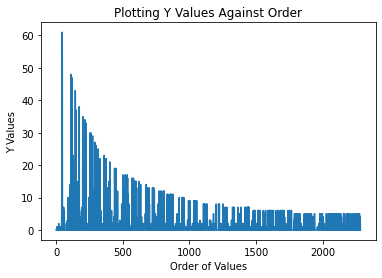

In [72]:
tag_id = 9
print(tags_users_freq['tags'][tag_id])
print(tags_users_freq['cv'][tag_id])
tag_count_selected = tags_users_freq['count'][tag_id]

y_values = tag_count_selected
x_values = range(len(tag_count_selected))

plt.plot(x_values, y_values)
plt.xlabel("Order of Values")
plt.ylabel("Y Values")
plt.title("Plotting Y Values Against Order")

plt.show()

In [76]:
tags_users_freq['cv'].describe()

count    6.000000
mean     1.344348
std      1.067378
min      0.000000
25%      0.439932
50%      1.837059
75%      1.931548
max      2.454704
Name: cv, dtype: float64

Save Point

In [ ]:
# # save tags_users_freq with cv as pickle
# tags_users_freq.to_pickle(path+'tags_users_freq.pkl')

tags_users_freq = pd.read_pickle(path+'tags_users_freq.pkl')

In [ ]:
# # save the data as pickle
# gdf.to_pickle(path+'gdf_reduce_bias.pkl')

# gdf = pd.read_pickle(path+'gdf_reduce_bias.pkl')

In [ ]:
# group data by users again
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())


# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

tags_count.most_common()

[('square', 13528),
 ('squareformat', 11877),
 ('city', 10557),
 ('architecture', 8834),
 ('street', 7514),
 ('thames', 7183),
 ('people', 7135),
 ('europe', 6869),
 ('park', 6648),
 ('cycle', 4981),
 ('river', 4860),
 ('bus', 4753),
 ('summer', 4615),
 ('art', 4504),
 ('greenwich', 4238),
 ('building', 4094),
 ('urban', 4036),
 ('westminster', 3997),
 ('cycles', 3987),
 ('candid', 3975),
 ('bridge', 3971),
 ('diary', 3962),
 ('existence', 3958),
 ('lifeblogging', 3956),
 ('egzystencja', 3956),
 ('lifeblog', 3956),
 ('lifelog', 3956),
 ('biorhythms', 3956),
 ('monotonyoflife', 3956),
 ('biorytmy', 3956),
 ('graffiti', 3877),
 ('riverthames', 3843),
 ('geotagged', 3738),
 ('heathrow', 3664),
 ('station', 3600),
 ('night', 3573),
 ('workplaceexperts', 3532),
 ('heathrowairport', 3493),
 ('travel', 3376),
 ('greatbritishrestaurant', 3302),
 ('olympics', 3216),
 ('blackandwhite', 3211),
 ('british', 3183),
 ('tower', 3138),
 ('museum', 3126),
 ('great', 3101),
 ('railway', 3086),
 ('shored

# Extract Locals and Tourists

## Get Users Profiles and Time Interval

In [ ]:
# get the location and time interval of users to extract locals and tourists


# https://www.flickr.com/services/api/flickr.profile.getProfile.html
# https://www.flickr.com/services/api/flickr.people.getInfo.html


## Add your API Key and secret of Flickr
key = "13a11e590b46b6df8b1ade8f43952de5"
secret = "36f95562873e66b3"

# connecting to Flickr
flickr = FlickrAPI(key, secret, format='parsed-json')

# create a dictionary to store the users profile (hometown, city, country)
users_profile = {}
# create a dictionary to store the time interval between the first and last photos of users
users_interval = {}

# iterate users
for i in tqdm.tqdm(users):
  # get the profile
  result = flickr.profile.getProfile(user_id=i)

  # set locations as NaN in case some of them are missing
  hometown = 'None'
  city = 'None'
  country = 'None'

  # get locations from the profile if they exist
  if 'hometown' in result['profile'].keys():
    if result['profile']['hometown'] != '':
      hometown = result['profile']['hometown']
      print('hometown:'+hometown)
  if 'city' in result['profile'].keys():
    if result['profile']['city'] != '' and result['profile']['city'] != None:
      city = result['profile']['city']
      print('city:'+city)
  if 'country' in result['profile'].keys():
    if result['profile']['country'] != '' and result['profile']['country'] != None:
      country = result['profile']['country']
  
  # add the list of locations to the profile of this user
  users_profile[i] = [hometown, city, country]
  

  # get the user data
  user = gdf_gb_users.get_group(i)
  user = user.sort_values('date')
  # get the time interval (days)
  if len(user) == 1:
    interval = 1
  else:
    interval = (user['date'].iloc[-1] - user['date'].iloc[0]).days + 1
  users_interval[i] = [interval]


In [ ]:
# convert the dictionary to the dataframe
users_profile = pd.DataFrame(users_profile).transpose()
users_interval = pd.DataFrame(users_interval).transpose()
# convert the index to the column
users_profile = users_profile.reset_index()
users_interval = users_interval.reset_index()
# rename the columns
users_profile.columns = ['owner', 'hometown', 'city', 'country']
users_interval.columns = ['owner', 'interval']

# join two dataframes
users_info = users_profile.merge(users_interval, on='owner')

# save the data as pickle
users_info.to_pickle(path+'flickr_users_info.pkl')

In [ ]:
users_info = pd.read_pickle(path+'flickr_users_info.pkl')
users_info

,owner,hometown,city,country,interval
0,100055988@N08,None,None,None,51
1,100092947@N05,None,None,None,1
2,100124573@N08,None,None,None,424
3,100198899@N03,None,None,None,1
4,100227835@N06,None,None,None,1
...,...,...,...,...,...
5152,99903552@N00,Iquique,Santiago de Chile,Chile,8
5153,99929871@N00,Wimbledon,Wimbledon,UK,1
5154,99954565@N02,None,None,None,1
5155,9996375@N05,None,London,United Kingdom,18


### Determine the Threshold for Time Interval

In [ ]:
locals_candi = users_info[(users_info['hometown'].str.contains('London')==True) | (users_info['city'].str.contains('London')==True)]
locals_candi

,owner,hometown,city,country,interval
5,10103515@N07,London,London,England,56
11,10332960@N03,London,Musselburgh,Scotland,273
12,103429480@N03,Valencia (Spain),London,UK,1
15,10396813@N04,Oswestry,London Town,United Kingdom,246
31,10865013@N05,London,London,England,97
...,...,...,...,...,...
1057,96735117@N03,London,NaN,NaN,203
1063,97938415@N00,Norwich,London,UK,245
1068,98587546@N00,Manchester,London,England,283
1075,99145208@N00,NaN,London,UK,3


In [ ]:
locals_candi['interval'].describe()

count    181.00000
mean     136.61326
std      127.97072
min        1.00000
25%        1.00000
50%      112.00000
75%      253.00000
max      364.00000
Name: interval, dtype: float64

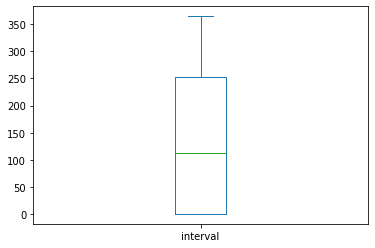

In [ ]:
locals_candi['interval'].plot.box()

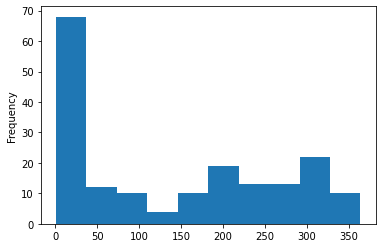

In [ ]:
locals_candi['interval'].plot.hist()

In [ ]:
len(users_info)

1083

In [ ]:
tourists_candi = users_info.loc[users_info.index.difference(locals_candi.index)]
tourists_candi

,owner,hometown,city,country,interval
0,100251406@N07,Alger,NaN,NaN,4
1,100350464@N04,Strasbourg,NaN,NaN,3
2,100872466@N04,NaN,NaN,NaN,1
3,100940682@N04,NaN,NaN,NaN,1
4,100978997@N07,Hämeenlinna,Iisalmi,Finland,3
...,...,...,...,...,...
1078,9937468@N08,NaN,NaN,NaN,1
1079,99656237@N00,NaN,NaN,NaN,1
1080,99713555@N00,NaN,Moerfelden-Walldorf,Germany,1
1081,99809597@N00,NaN,NaN,NaN,1


In [ ]:
tourists_candi['interval'].describe()

count    902.000000
mean      59.248337
std      103.245246
min        1.000000
25%        1.000000
50%        2.000000
75%       61.750000
max      362.000000
Name: interval, dtype: float64

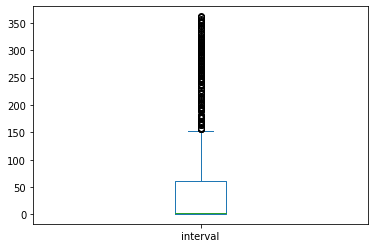

In [ ]:
tourists_candi['interval'].plot.box()

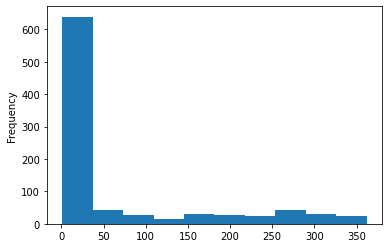

In [ ]:
tourists_candi['interval'].plot.hist()

In [ ]:
tourists_candi[tourists_candi['interval'] < 30]

,owner,hometown,city,country,interval
0,100251406@N07,Alger,NaN,NaN,4
1,100350464@N04,Strasbourg,NaN,NaN,3
2,100872466@N04,NaN,NaN,NaN,1
3,100940682@N04,NaN,NaN,NaN,1
4,100978997@N07,Hämeenlinna,Iisalmi,Finland,3
...,...,...,...,...,...
1078,9937468@N08,NaN,NaN,NaN,1
1079,99656237@N00,NaN,NaN,NaN,1
1080,99713555@N00,NaN,Moerfelden-Walldorf,Germany,1
1081,99809597@N00,NaN,NaN,NaN,1


## Extract Two Groups of Users

In [ ]:
users_info['city'][0]

'None'

In [ ]:
type(users_info['hometown'][0])

str

In [ ]:
# add the column tourist to indicate whether the user is a tourist or a local (y means tourist, n means local)
# assume all users are tourists first
users_info['tourist'] = 'y'

# iterate users to find locals based on the user profile and interval
for idx, row in users_info.iterrows():
  # label the users whose hometown or city is London as locals
  if row['hometown'] != 'None' or row['city'] != 'None':
    if 'London' in row['hometown'] or 'London' in row['city']:
      users_info.loc[idx, 'tourist'] = 'n'
  # labels the users who do not have hometown or city information, and whose interval larger than 30 as locals
  else:
    if row['interval'] > 30:
      users_info.at[idx, 'tourist'] = 'n'


In [ ]:
users_info[users_info['tourist']=='y']


,owner,hometown,city,country,interval,tourist
1,100092947@N05,None,None,None,1,y
3,100198899@N03,None,None,None,1,y
4,100227835@N06,None,None,None,1,y
5,100300580@N08,None,None,England,1,y
6,100345803@N03,None,None,None,15,y
...,...,...,...,...,...,...
5151,99848695@N07,None,None,None,1,y
5152,99903552@N00,Iquique,Santiago de Chile,Chile,8,y
5153,99929871@N00,Wimbledon,Wimbledon,UK,1,y
5154,99954565@N02,None,None,None,1,y


In [ ]:
users_info[users_info['tourist']=='n']

,owner,hometown,city,country,interval,tourist
0,100055988@N08,None,None,None,51,n
2,100124573@N08,None,None,None,424,n
8,100492172@N06,London,London,UK,449,n
16,10076455@N04,None,None,None,427,n
25,10103515@N07,London,London,England,479,n
...,...,...,...,...,...,...
5129,99366204@N06,None,London,England,1,n
5133,99456529@N00,Newcastle-Upon-Tyne,Brockley SE4 London,UK,437,n
5142,99656237@N00,None,None,None,513,n
5149,99809597@N00,None,None,None,518,n


In [ ]:
# join the users information to gdf
gdf = gdf.join(users_info[['owner', 'tourist']].set_index('owner'), on='owner')
gdf

,owner,accuracy,datetaken,tags,title,geometry,date,tourist
104214,130584709@N06,15.0,2012-04-03 00:02:14,forms workplaceexperts glass circles duotone n...,Londres. el Tower Bridge,POINT (-0.07843 51.51040),2012-04-03,y
104215,130584709@N06,15.0,2012-04-03 00:03:37,vase muses antique glass nude reference classi...,Londres.The Sharp,POINT (-0.07787 51.50901),2012-04-03,y
104216,130584709@N06,15.0,2012-04-03 00:07:47,bluesky clouds greenwich architecture greenwic...,Londres.,POINT (-0.07787 51.50901),2012-04-03,y
104217,130584709@N06,15.0,2012-04-03 00:08:15,,Londres. el Tower Bridge,POINT (-0.07542 51.50582),2012-04-03,y
104218,130584709@N06,15.0,2012-04-03 00:09:23,square squareformat,"Londres, Torre de Londres",POINT (-0.07688 51.50832),2012-04-03,y
...,...,...,...,...,...,...,...,...
339455,86814251@N00,16.0,2013-09-16 20:41:35,millenniumbridge stpaul eosm riverthames,NaN,POINT (-0.09851 51.50959),2013-09-16,y
339456,86814251@N00,16.0,2013-09-16 20:44:58,eosm,NaN,POINT (-0.09853 51.50961),2013-09-16,y
339457,86814251@N00,16.0,2013-09-16 20:46:41,millenniumbridge stpaul eosm,NaN,POINT (-0.09853 51.50961),2013-09-16,y
339480,86814251@N00,16.0,2013-09-16 22:17:49,eosm towerbridge riverthames,NaN,POINT (-0.07886 51.50518),2013-09-16,y


Save Point

Save the cleaned data as pickle

In [ ]:
# # save the cleaned gdf with locals/tourists identified as pickle
# gdf.to_pickle(path+'london_flickr_cleaned.pkl')

gdf = pd.read_pickle(path+'london_flickr_cleaned.pkl')

Save the cleaned data as csv

In [ ]:
# convert geodataframe to dataframe
gdf['lon'] = 0
gdf['lat'] = 0

gdf['lon'] = gdf['geometry'].apply(lambda geo: geo.x)
gdf['lat'] = gdf['geometry'].apply(lambda geo: geo.y)

gdf = gdf.drop(columns='geometry')

gdf = pd.DataFrame(gdf)

gdf


,owner,accuracy,datetaken,tags,title,date,tourist,lon,lat
104214,130584709@N06,15.0,2012-04-03 00:02:14,forms workplaceexperts glass circles duotone n...,Londres. el Tower Bridge,2012-04-03,y,-0.078427,51.510398
104215,130584709@N06,15.0,2012-04-03 00:03:37,vase muses antique glass nude reference classi...,Londres.The Sharp,2012-04-03,y,-0.077869,51.509009
104216,130584709@N06,15.0,2012-04-03 00:07:47,bluesky clouds greenwich architecture greenwic...,Londres.,2012-04-03,y,-0.077869,51.509009
104217,130584709@N06,15.0,2012-04-03 00:08:15,,Londres. el Tower Bridge,2012-04-03,y,-0.075423,51.505817
104218,130584709@N06,15.0,2012-04-03 00:09:23,square squareformat,"Londres, Torre de Londres",2012-04-03,y,-0.076882,51.508315
...,...,...,...,...,...,...,...,...,...
339455,86814251@N00,16.0,2013-09-16 20:41:35,millenniumbridge stpaul eosm riverthames,NaN,2013-09-16,y,-0.098506,51.509594
339456,86814251@N00,16.0,2013-09-16 20:44:58,eosm,NaN,2013-09-16,y,-0.098531,51.509611
339457,86814251@N00,16.0,2013-09-16 20:46:41,millenniumbridge stpaul eosm,NaN,2013-09-16,y,-0.098531,51.509611
339480,86814251@N00,16.0,2013-09-16 22:17:49,eosm towerbridge riverthames,NaN,2013-09-16,y,-0.078856,51.505175


In [ ]:
# # save the cleaned data as csv
# gdf.to_csv(path+'london_flickr_cleaned.csv')

gdf = pd.read_csv(path+'london_flickr_cleaned.csv')

In [ ]:
gdf

,owner,accuracy,datetaken,tags,title,date,tourist,lon,lat
104214,130584709@N06,15.0,2012-04-03 00:02:14,forms workplaceexperts glass circles duotone n...,Londres. el Tower Bridge,2012-04-03,y,-0.078427,51.510398
104215,130584709@N06,15.0,2012-04-03 00:03:37,vase muses antique glass nude reference classi...,Londres.The Sharp,2012-04-03,y,-0.077869,51.509009
104216,130584709@N06,15.0,2012-04-03 00:07:47,bluesky clouds greenwich architecture greenwic...,Londres.,2012-04-03,y,-0.077869,51.509009
104217,130584709@N06,15.0,2012-04-03 00:08:15,,Londres. el Tower Bridge,2012-04-03,y,-0.075423,51.505817
104218,130584709@N06,15.0,2012-04-03 00:09:23,square squareformat,"Londres, Torre de Londres",2012-04-03,y,-0.076882,51.508315
...,...,...,...,...,...,...,...,...,...
339455,86814251@N00,16.0,2013-09-16 20:41:35,millenniumbridge stpaul eosm riverthames,NaN,2013-09-16,y,-0.098506,51.509594
339456,86814251@N00,16.0,2013-09-16 20:44:58,eosm,NaN,2013-09-16,y,-0.098531,51.509611
339457,86814251@N00,16.0,2013-09-16 20:46:41,millenniumbridge stpaul eosm,NaN,2013-09-16,y,-0.098531,51.509611
339480,86814251@N00,16.0,2013-09-16 22:17:49,eosm towerbridge riverthames,NaN,2013-09-16,y,-0.078856,51.505175


In [ ]:
len(list(gdf['owner'].unique()))

5157

In [ ]:
# group data by users
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())


# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())


In [ ]:
tags_count.most_common()

[('square', 13528),
 ('squareformat', 11877),
 ('city', 10557),
 ('architecture', 8834),
 ('street', 7514),
 ('thames', 7183),
 ('people', 7135),
 ('europe', 6869),
 ('park', 6648),
 ('cycle', 4981),
 ('river', 4860),
 ('bus', 4753),
 ('summer', 4615),
 ('art', 4504),
 ('greenwich', 4238),
 ('building', 4094),
 ('urban', 4036),
 ('westminster', 3997),
 ('cycles', 3987),
 ('candid', 3975),
 ('bridge', 3971),
 ('diary', 3962),
 ('existence', 3958),
 ('lifeblogging', 3956),
 ('egzystencja', 3956),
 ('lifeblog', 3956),
 ('lifelog', 3956),
 ('biorhythms', 3956),
 ('monotonyoflife', 3956),
 ('biorytmy', 3956),
 ('graffiti', 3877),
 ('riverthames', 3843),
 ('geotagged', 3738),
 ('heathrow', 3664),
 ('station', 3600),
 ('night', 3573),
 ('workplaceexperts', 3532),
 ('heathrowairport', 3493),
 ('travel', 3376),
 ('greatbritishrestaurant', 3302),
 ('olympics', 3216),
 ('blackandwhite', 3211),
 ('british', 3183),
 ('tower', 3138),
 ('museum', 3126),
 ('great', 3101),
 ('railway', 3086),
 ('shored

In [ ]:
len(tags_unique)

79804

# Explore Data

## Locals

In [ ]:
# get the locals
df_locals = gdf[gdf['tourist']=='n']
df_locals


,owner,accuracy,datetaken,tags,title,geometry,date,tourist
104348,34427470616@N01,16.0,2012-04-03 07:48:08,earo graffit graffiti southbank,"Earo graffiti, Southbank",POINT (-0.11699 51.50664),2012-04-03,n
104349,34427470616@N01,16.0,2012-04-03 07:48:41,lifeblogging egzystencja lifeblog lifelog cycl...,TeamV graffiti,POINT (-0.11699 51.50664),2012-04-03,n
104350,34427470616@N01,16.0,2012-04-03 07:48:52,roof museum totempole greatcourt britishmuseum...,street art,POINT (-0.11699 51.50664),2012-04-03,n
104351,34427470616@N01,16.0,2012-04-03 07:49:23,typeofstructure structuresarchitecture governm...,Our diamond queen,POINT (-0.11699 51.50664),2012-04-03,n
104352,34427470616@N01,16.0,2012-04-03 07:49:42,square xproii squareformat,Our Diamond Queen,POINT (-0.11699 51.50664),2012-04-03,n
...,...,...,...,...,...,...,...,...
339070,26300494@N07,16.0,2013-09-16 18:13:10,chimney,NaN,POINT (-0.18238 51.47556),2013-09-16,n
339071,26300494@N07,16.0,2013-09-16 18:15:56,chimney road people ssc,NaN,POINT (-0.18329 51.47662),2013-09-16,n
339072,26300494@N07,16.0,2013-09-16 18:17:24,bird shard ssc skyline,NaN,POINT (-0.18271 51.47697),2013-09-16,n
339074,26300494@N07,16.0,2013-09-16 18:17:41,ssc shard skyline,NaN,POINT (-0.18271 51.47697),2013-09-16,n


In [ ]:
len(list(df_locals['owner'].unique()))

1409

In [ ]:
# get all tags of locals
tags_locals = list(df_locals['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags_locals = list(np.concatenate(tags_locals).flat)

# count tags
tags_count_locals = Counter(tags_locals)

# get the list of unique tags
tags_unique_locals = list(tags_count_locals.keys())


In [ ]:
len(tags_unique_locals)

56095

In [ ]:
tags_count_locals.most_common()

[('square', 6308),
 ('squareformat', 5567),
 ('people', 5008),
 ('city', 4841),
 ('architecture', 4385),
 ('park', 3969),
 ('street', 3894),
 ('thames', 3397),
 ('candid', 3013),
 ('europe', 2867),
 ('summer', 2669),
 ('graffiti', 2484),
 ('river', 2452),
 ('art', 2366),
 ('urban', 2237),
 ('bus', 1977),
 ('building', 1913),
 ('shoreditch', 1910),
 ('workplaceexperts', 1875),
 ('greenwich', 1873),
 ('riverthames', 1809),
 ('geotagged', 1774),
 ('night', 1772),
 ('bridge', 1740),
 ('station', 1724),
 ('greatbritishrestaurant', 1670),
 ('buildings', 1656),
 ('olympics', 1645),
 ('tube', 1626),
 ('railway', 1586),
 ('southbank', 1564),
 ('blackandwhite', 1561),
 ('streetart', 1555),
 ('girl', 1548),
 ('underground', 1516),
 ('gig', 1474),
 ('westminster', 1454),
 ('live', 1442),
 ('camden', 1423),
 ('music', 1416),
 ('road', 1358),
 ('train', 1343),
 ('show', 1339),
 ('water', 1307),
 ('eyefi', 1290),
 ('red', 1279),
 ('spring', 1277),
 ('cycle', 1268),
 ('hampstead', 1237),
 ('tourists',

## Tourists

In [ ]:
# get the tourists
df_tourists = gdf[gdf['tourist']=='y']
df_tourists

,owner,accuracy,datetaken,tags,title,geometry,date,tourist
104214,130584709@N06,15.0,2012-04-03 00:02:14,forms workplaceexperts glass circles duotone n...,Londres. el Tower Bridge,POINT (-0.07843 51.51040),2012-04-03,y
104215,130584709@N06,15.0,2012-04-03 00:03:37,vase muses antique glass nude reference classi...,Londres.The Sharp,POINT (-0.07787 51.50901),2012-04-03,y
104216,130584709@N06,15.0,2012-04-03 00:07:47,bluesky clouds greenwich architecture greenwic...,Londres.,POINT (-0.07787 51.50901),2012-04-03,y
104217,130584709@N06,15.0,2012-04-03 00:08:15,,Londres. el Tower Bridge,POINT (-0.07542 51.50582),2012-04-03,y
104218,130584709@N06,15.0,2012-04-03 00:09:23,square squareformat,"Londres, Torre de Londres",POINT (-0.07688 51.50832),2012-04-03,y
...,...,...,...,...,...,...,...,...
339455,86814251@N00,16.0,2013-09-16 20:41:35,millenniumbridge stpaul eosm riverthames,NaN,POINT (-0.09851 51.50959),2013-09-16,y
339456,86814251@N00,16.0,2013-09-16 20:44:58,eosm,NaN,POINT (-0.09853 51.50961),2013-09-16,y
339457,86814251@N00,16.0,2013-09-16 20:46:41,millenniumbridge stpaul eosm,NaN,POINT (-0.09853 51.50961),2013-09-16,y
339480,86814251@N00,16.0,2013-09-16 22:17:49,eosm towerbridge riverthames,NaN,POINT (-0.07886 51.50518),2013-09-16,y


In [ ]:
len(list(df_tourists['owner'].unique()))

3748

In [ ]:
# get all tags of tourists
tags_tourists = list(df_tourists['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags_tourists = list(np.concatenate(tags_tourists).flat)

# count tags
tags_count_tourists = Counter(tags_tourists)

# get the list of unique tags
tags_unique_tourists = list(tags_count_tourists.keys())


In [ ]:
len(tags_unique_tourists)

53615

In [ ]:
tags_count_tourists.most_common()

[('square', 7220),
 ('squareformat', 6310),
 ('city', 5716),
 ('architecture', 4449),
 ('europe', 4002),
 ('thames', 3786),
 ('cycle', 3713),
 ('street', 3620),
 ('cycles', 3440),
 ('diary', 3435),
 ('existence', 3432),
 ('lifeblogging', 3430),
 ('egzystencja', 3430),
 ('lifeblog', 3430),
 ('lifelog', 3430),
 ('biorhythms', 3430),
 ('monotonyoflife', 3430),
 ('biorytmy', 3430),
 ('bus', 2776),
 ('park', 2679),
 ('westminster', 2543),
 ('travel', 2505),
 ('great', 2442),
 ('heathrow', 2436),
 ('river', 2408),
 ('heathrowairport', 2373),
 ('greenwich', 2365),
 ('bridge', 2231),
 ('building', 2181),
 ('art', 2138),
 ('people', 2127),
 ('british', 2052),
 ('riverthames', 2034),
 ('inglaterra', 2027),
 ('geotagged', 1964),
 ('museum', 1962),
 ('tower', 1955),
 ('summer', 1946),
 ('station', 1876),
 ('night', 1801),
 ('urban', 1799),
 ('capital', 1783),
 ('alpha', 1685),
 ('egll', 1676),
 ('grosbritannien', 1662),
 ('workplaceexperts', 1657),
 ('blackandwhite', 1650),
 ('south', 1646),
 ('gr

# Visualize Data

In [ ]:
# # visualize the distribution of photos taken by the specific user
# user_test = gdf_gb_users.get_group('64639998@N00')

# map = folium.Map(location = [51.9,0], zoom_start = 10)

# for date, title, tags, geometry in user_test[['datetaken', 'title', 'tags', 'geometry']].values:
#     # Place the markers with the popup labels and data
#     folium.Marker(location = [geometry.xy[1][0], geometry.xy[0][0]],
#                   tooltip ='<strong>Date: </strong>{0}<br><strong>Title: </strong>{1}</br><strong>Tags: </strong>{2}'.format(date, title, tags)
#                   ).add_to(map)

# map


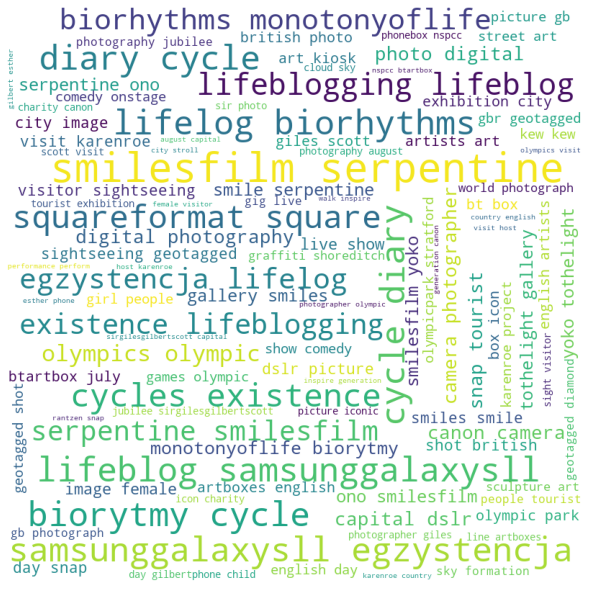

In [ ]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in tags:
  # split the value
  tokens = val.split()
  
  # Converts each token into lowercase
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [ ]:
tags_count.most_common()

[('olympics', 20423),
 ('serpentine', 11769),
 ('city', 11261),
 ('smilesfilm', 11211),
 ('canon', 9791),
 ('square', 9105),
 ('olympic', 8995),
 ('art', 8576),
 ('geotagged', 7905),
 ('gb', 7714),
 ('thames', 7534),
 ('park', 7447),
 ('squareformat', 7358),
 ('street', 7287),
 ('cycle', 7050),
 ('europe', 6921),
 ('architecture', 6666),
 ('people', 6647),
 ('londres', 6453),
 ('cycles', 6352),
 ('diary', 6248),
 ('existence', 6233),
 ('biorytmy', 6232),
 ('lifeblogging', 6232),
 ('lifeblog', 6232),
 ('samsunggalaxysll', 6232),
 ('egzystencja', 6232),
 ('lifelog', 6232),
 ('biorhythms', 6232),
 ('monotonyoflife', 6232),
 ('gbr', 5706),
 ('british', 5630),
 ('music', 5435),
 ('capital', 5402),
 ('photography', 5350),
 ('live', 5149),
 ('summer', 5034),
 ('english', 5030),
 ('river', 5017),
 ('graffiti', 4950),
 ('photo', 4848),
 ('museum', 4807),
 ('olympicgames', 4796),
 ('greenwich', 4758),
 ('paralympics', 4601),
 ('gig', 4535),
 ('show', 4346),
 ('shoreditch', 4275),
 ('urban', 4242